# Introduction
Thank you for reviewing my DTSA-5509 final project. In this project, I compare different machine learning techniques to evaluate their performance on a **text classification problem**.

A bit of background — I work in IT and am approaching this project as a first step toward developing a model that can automatically classify IT support requests. My end goal would be to automatically route support tickets to the appropriate places for resolution.

For this project, I chose the [IT Service Ticket Classification Dataset](https://www.kaggle.com/datasets/adisongoh/it-service-ticket-classification-dataset?resource=download), which provides labeled IT support tickets similar to the type that I will be handling in my final implementation. I chose not to track the source data .csv in this repo as it is a bit large for Git (14 megs). If you want to recreate this project in your own environment, you'll need to download the .csv available at the link above.

## Problem Statement
In IT support, different individuals or AI agents specialize in handling specific types of requests. For example:

+ Person A may be responsible for resolving technical issues with System X.
+ AI Agent B might handle user access requests for Platform Y.

Without an automated system for classifying such requests, IT support teams must manually triage and route tickets, which can be inefficient and error-prone. This project explores machine learning techniques to automate these routing decisions.

For this project, I compare supervised learning techniques covered in *DTSA-5509 Introduction to Machine Learning: Supervised Learning* in the CU Boulder MS-DS program. While more advanced models (such as neural networks) may yield further improvements, this project focuses 
on exploring techniques taught in the course.

## Exploratory Data Analysis

### Import Data

In [2]:
import pandas as pd

all_tickets = pd.read_csv('all_tickets_processed_improved_v3.csv')
print(all_tickets.head())
print(f"\n{all_tickets.shape[0]} rows and {all_tickets.shape[1]} columns")

                                            Document    Topic_group
0  connection with icon icon dear please setup ic...       Hardware
1  work experience user work experience user hi w...         Access
2  requesting for meeting requesting meeting hi p...       Hardware
3  reset passwords for external accounts re expir...         Access
4  mail verification warning hi has got attached ...  Miscellaneous

47837 rows and 2 columns


The `all_tickets` data frame has two columns: 
+ `Document` – this column contains text from IT support requests
+ `Topic_group` – this column represents the category of the request (i.e., the routing decision)


For this project, we will:

+ Treat the text within `Document` as the feature variables (X) that our model will use for classification.
+ Treat `Topic_group` as the dependent variable (y), representing the classes (the routing decisions) that we want our model to predict.

### Distribution of IT Support Request Types

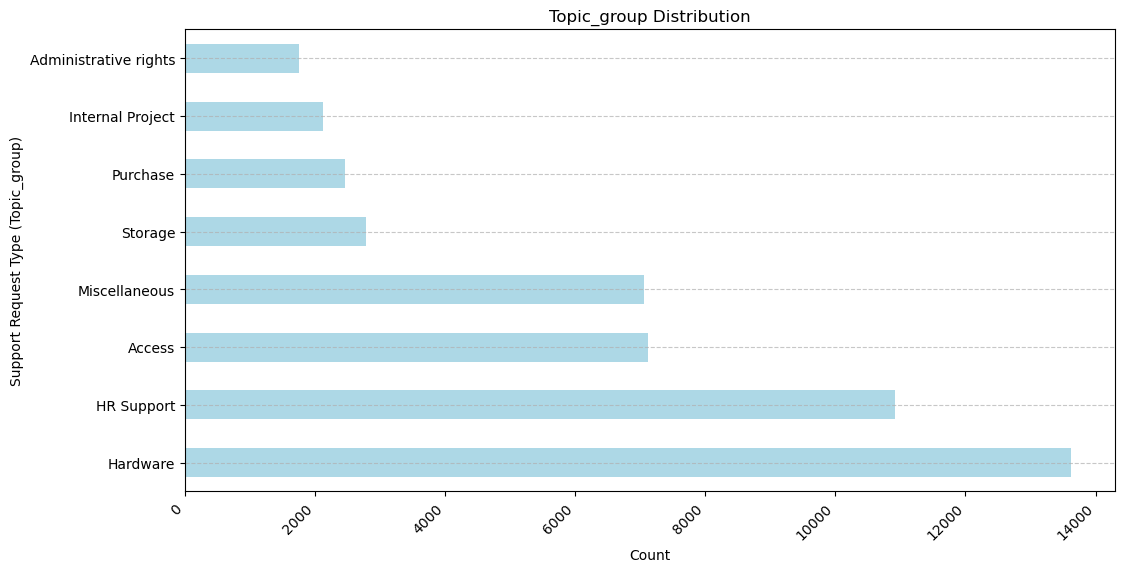

In [34]:
import matplotlib.pyplot as plt

topic_group_counts = all_tickets["Topic_group"].value_counts()

plt.figure(figsize=(12, 6))
topic_group_counts.plot(kind="barh", color='lightblue')
plt.xlabel("Count")
plt.ylabel("Support Request Type (Topic_group)")
plt.title("Topic_group Distribution")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

The different types of support requests are unevenly distributed, with "Hardware" and "HR Support" having significantly more instances than others. We'll have to make sure the train and test sets follow the same distribution seen here.

### Bag-of-Words Text Representation

We will utilize the [Bag-of-Words (BoW)](https://en.wikipedia.org/wiki/Bag-of-words_model) technique for encoding the `Document` text into numerical form.

To give examples from rows 238, 307, and 338 in `all_tickets`:

| Row # | `Document` text                              |
|-------|---------------------------------------------|
| 238   | access re please provide also thanks       |
| 307   | account for hi please create thank head    |
| 338   | access great hi please mailbox thank       |

The Bag-of-Words encoding of these rows puts each unique word into its own column, with numbers representing the word counts:

| Row # | access | re | please | provide | also | thanks | account | for | hi | create | thank | head | great | mailbox |
|-------|--------|----|--------|---------|------|--------|---------|----|----|--------|-------|------|-------|---------|
| 238   | 1      | 1  | 1      | 1       | 1    | 1      | 0       | 0  | 0  | 0      | 0     | 0    | 0     | 0       |
| 307   | 0      | 0  | 1      | 0       | 0    | 0      | 1       | 1  | 1  | 1      | 1     | 1    | 0     | 0       |
| 338   | 1      | 0  | 1      | 0       | 0    | 0      | 0       | 0  | 1  | 0      | 1     | 0    | 1     | 1       |


## Data Preparation

 Before converting the `Document` column into a bag-of-words matrix, we use the [spaCy library](https://spacy.io/) to perform the following on the `Document` text:
 + [tokenization](https://en.wikipedia.org/wiki/Lexical_analysis#Tokenization) (separating sentences into individual words)
 + [stopword removal](https://en.wikipedia.org/wiki/Stop_word#:~:text=Stop%20words%20are%20the%20words,because%20they%20are%20deemed%20insignificant.) (removing common words like "the", "a", "an")
 + [lemmatization](https://en.wikipedia.org/wiki/Lemmatization) (reducing different variations of words into their base form - e.g. "running" becomes "run")

 Why are we adding these steps? Because they will improve the accuracy and efficiency of the model.  
 Removing words with low semantic content reduces noise in the data, allowing the model to focus on meanfingful words that influence the classification.

In [4]:
import spacy
nlp = spacy.load("en_core_web_sm")

def preprocess_text(text):
    doc = nlp(text.lower())
    cleaned_tokens = [token.lemma_ for token in doc if token.is_alpha and not token.is_stop]
    return " ".join(cleaned_tokens)

all_tickets["Document"] = all_tickets["Document"].apply(preprocess_text)

Next, we transform the `Document` column in `all_tickets` into a bag-of-words matrix (X). Then we form a new data frame called `all_tickets_bow_df` rejoining X with the `Topic_group` dependent variable (y).

In [5]:
from sklearn.feature_extraction.text import CountVectorizer

# Extract the Document and Topic_group columns from all_tickets
documents = all_tickets["Document"]
y = all_tickets["Topic_group"]

# Apply Bag-of-Words transformation
vectorizer = CountVectorizer(stop_words='english')
bow = vectorizer.fit_transform(documents)
X = pd.DataFrame(bow.toarray(), columns=vectorizer.get_feature_names_out())

# Rejoin X with y
all_tickets_bow_df = pd.concat([X, y.reset_index(drop=True)], axis=1)
print(f"\n{all_tickets_bow_df.shape[0]} rows and {all_tickets_bow_df.shape[1]} columns.\n")



47837 rows and 9298 columns.



We now split the data into train and test sets. We'll use the `stratify=y` parameter in `train_test_spit` to ensure the class distribution in the train and test sets matches the distribution in the original `all_tickets` data.

In [6]:
from sklearn.model_selection import train_test_split

X = all_tickets_bow_df.drop(columns=["Topic_group"])
y = all_tickets_bow_df["Topic_group"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set: {X_train.shape[0]} rows and {X_train.shape[1]} columns")
print(f"Test set: {X_test.shape[0]} rows and {X_test.shape[1]} columns")

Training set: 38269 rows and 9297 columns
Test set: 9568 rows and 9297 columns


## Model Building and Analysis

### Logistic Regression

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)
y_pred_log_reg = log_reg.predict(X_test)

print("Logistic Regression Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_log_reg):.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_log_reg))

Logistic Regression Performance:
Accuracy: 0.8332

Classification Report:
                        precision    recall  f1-score   support

               Access       0.88      0.88      0.88      1425
Administrative rights       0.78      0.69      0.73       352
           HR Support       0.83      0.84      0.84      2183
             Hardware       0.80      0.82      0.81      2724
     Internal Project       0.87      0.85      0.86       424
        Miscellaneous       0.79      0.79      0.79      1412
             Purchase       0.95      0.88      0.92       493
              Storage       0.88      0.87      0.88       555

             accuracy                           0.83      9568
            macro avg       0.85      0.83      0.84      9568
         weighted avg       0.83      0.83      0.83      9568



### KNN

In [9]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

print("KNN Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_knn):.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_knn))

KNN Performance:
Accuracy: 0.7181

Classification Report:
                        precision    recall  f1-score   support

               Access       0.76      0.81      0.79      1425
Administrative rights       0.59      0.52      0.55       352
           HR Support       0.59      0.88      0.71      2183
             Hardware       0.80      0.62      0.70      2724
     Internal Project       0.80      0.67      0.73       424
        Miscellaneous       0.74      0.59      0.66      1412
             Purchase       0.95      0.84      0.89       493
              Storage       0.85      0.72      0.78       555

             accuracy                           0.72      9568
            macro avg       0.76      0.71      0.72      9568
         weighted avg       0.74      0.72      0.72      9568



### Decision Tree

In [10]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

print("Decision Tree Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_dt):.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_dt))

Decision Tree Performance:
Accuracy: 0.7652

Classification Report:
                        precision    recall  f1-score   support

               Access       0.83      0.84      0.84      1425
Administrative rights       0.73      0.68      0.71       352
           HR Support       0.79      0.78      0.78      2183
             Hardware       0.74      0.74      0.74      2724
     Internal Project       0.73      0.77      0.75       424
        Miscellaneous       0.69      0.71      0.70      1412
             Purchase       0.88      0.83      0.85       493
              Storage       0.82      0.77      0.80       555

             accuracy                           0.77      9568
            macro avg       0.77      0.77      0.77      9568
         weighted avg       0.77      0.77      0.77      9568



### Random Forest (100 estimators)

In [11]:
from sklearn.ensemble import RandomForestClassifier

rf1 = RandomForestClassifier(n_estimators=100, random_state=42)
rf1.fit(X_train, y_train)
y_pred_rf1 = rf1.predict(X_test)

print("Random Forest Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf1):.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf1))

Random Forest Performance:
Accuracy: 0.8314

Classification Report:
                        precision    recall  f1-score   support

               Access       0.88      0.86      0.87      1425
Administrative rights       0.92      0.59      0.72       352
           HR Support       0.83      0.86      0.85      2183
             Hardware       0.77      0.87      0.81      2724
     Internal Project       0.89      0.80      0.85       424
        Miscellaneous       0.81      0.76      0.79      1412
             Purchase       0.97      0.86      0.91       493
              Storage       0.94      0.81      0.87       555

             accuracy                           0.83      9568
            macro avg       0.88      0.80      0.83      9568
         weighted avg       0.84      0.83      0.83      9568



### Random Forest (300 estimators)

In [12]:
rf2 = RandomForestClassifier(n_estimators=300, random_state=42)
rf2.fit(X_train, y_train)
y_pred_rf2 = rf2.predict(X_test)

print("Random Forest Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf2):.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf2))

Random Forest Performance:
Accuracy: 0.8378

Classification Report:
                        precision    recall  f1-score   support

               Access       0.90      0.86      0.88      1425
Administrative rights       0.94      0.59      0.73       352
           HR Support       0.85      0.86      0.85      2183
             Hardware       0.77      0.88      0.82      2724
     Internal Project       0.89      0.80      0.84       424
        Miscellaneous       0.81      0.78      0.79      1412
             Purchase       0.96      0.86      0.91       493
              Storage       0.94      0.81      0.87       555

             accuracy                           0.84      9568
            macro avg       0.88      0.80      0.84      9568
         weighted avg       0.84      0.84      0.84      9568



### Random Forest (600 estimators)

In [13]:
rf3 = RandomForestClassifier(n_estimators=600, random_state=42)
rf3.fit(X_train, y_train)
y_pred_rf3 = rf3.predict(X_test)

print("Random Forest Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf3):.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf3))

Random Forest Performance:
Accuracy: 0.8386

Classification Report:
                        precision    recall  f1-score   support

               Access       0.90      0.87      0.88      1425
Administrative rights       0.93      0.61      0.74       352
           HR Support       0.85      0.86      0.85      2183
             Hardware       0.77      0.88      0.82      2724
     Internal Project       0.90      0.80      0.84       424
        Miscellaneous       0.81      0.78      0.79      1412
             Purchase       0.96      0.86      0.91       493
              Storage       0.94      0.81      0.87       555

             accuracy                           0.84      9568
            macro avg       0.88      0.81      0.84      9568
         weighted avg       0.84      0.84      0.84      9568



### Support Vector Machine (linear)

In [14]:
from sklearn.svm import SVC

svm_linear = SVC(kernel="linear", random_state=42)
svm_linear.fit(X_train, y_train)
y_pred_svm_linear = svm_linear.predict(X_test)

print("SVM Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_svm_linear):.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_svm_linear))

SVM Performance:
Accuracy: 0.8308

Classification Report:
                        precision    recall  f1-score   support

               Access       0.86      0.90      0.88      1425
Administrative rights       0.77      0.72      0.74       352
           HR Support       0.81      0.85      0.83      2183
             Hardware       0.82      0.81      0.82      2724
     Internal Project       0.86      0.83      0.85       424
        Miscellaneous       0.80      0.77      0.78      1412
             Purchase       0.93      0.90      0.92       493
              Storage       0.89      0.86      0.87       555

             accuracy                           0.83      9568
            macro avg       0.84      0.83      0.84      9568
         weighted avg       0.83      0.83      0.83      9568



### Support Vector Machine (RBF kernel)

In [15]:
from sklearn.svm import SVC

svm_rbf = SVC(kernel="rbf", random_state=42)
svm_rbf.fit(X_train, y_train)
y_pred_svm_rbf = svm_rbf.predict(X_test)

print("SVM Performance (RBF):")
print(f"Accuracy: {accuracy_score(y_test, y_pred_svm_rbf):.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_svm_rbf))

SVM Performance (RBF):
Accuracy: 0.8304

Classification Report:
                        precision    recall  f1-score   support

               Access       0.89      0.85      0.87      1425
Administrative rights       0.90      0.59      0.71       352
           HR Support       0.84      0.85      0.85      2183
             Hardware       0.75      0.88      0.81      2724
     Internal Project       0.89      0.75      0.82       424
        Miscellaneous       0.83      0.76      0.79      1412
             Purchase       0.97      0.87      0.92       493
              Storage       0.93      0.81      0.86       555

             accuracy                           0.83      9568
            macro avg       0.88      0.80      0.83      9568
         weighted avg       0.84      0.83      0.83      9568



### AdaBoost (100 estimators)

In [16]:
from sklearn.ensemble import AdaBoostClassifier

adaboost1 = AdaBoostClassifier(n_estimators=100, random_state=42)
adaboost1.fit(X_train, y_train)
y_pred_ab1 = adaboost1.predict(X_test)

print("AdaBoost Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_ab1):.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_ab1))

AdaBoost Performance:
Accuracy: 0.4278

Classification Report:
                        precision    recall  f1-score   support

               Access       0.90      0.13      0.23      1425
Administrative rights       0.80      0.19      0.31       352
           HR Support       0.72      0.27      0.40      2183
             Hardware       0.34      0.93      0.50      2724
     Internal Project       0.80      0.46      0.59       424
        Miscellaneous       0.25      0.06      0.10      1412
             Purchase       0.97      0.66      0.79       493
              Storage       0.83      0.17      0.28       555

             accuracy                           0.43      9568
            macro avg       0.70      0.36      0.40      9568
         weighted avg       0.60      0.43      0.38      9568



### AdaBoost (300 estimators)

In [17]:
base_estimator = DecisionTreeClassifier(max_depth=3, random_state=42)
adaboost2 = AdaBoostClassifier(estimator=base_estimator, n_estimators=300, random_state=42)
adaboost2.fit(X_train, y_train)
y_pred_ab2 = adaboost2.predict(X_test)


print("AdaBoost Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_ab2):.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_ab2))


AdaBoost Performance:
Accuracy: 0.7240

Classification Report:
                        precision    recall  f1-score   support

               Access       0.84      0.72      0.78      1425
Administrative rights       0.78      0.62      0.69       352
           HR Support       0.78      0.70      0.74      2183
             Hardware       0.60      0.81      0.69      2724
     Internal Project       0.76      0.76      0.76       424
        Miscellaneous       0.71      0.56      0.62      1412
             Purchase       0.94      0.85      0.89       493
              Storage       0.90      0.73      0.81       555

             accuracy                           0.72      9568
            macro avg       0.79      0.72      0.75      9568
         weighted avg       0.74      0.72      0.73      9568



### AdaBoost (600 estimators)

In [18]:
base_estimator = DecisionTreeClassifier(max_depth=4, random_state=42)
adaboost3 = AdaBoostClassifier(estimator=base_estimator, n_estimators=600, random_state=42)
adaboost3.fit(X_train, y_train)
y_pred_ab3 = adaboost3.predict(X_test)

print("AdaBoost Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_ab3):.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_ab3))

AdaBoost Performance:
Accuracy: 0.7504

Classification Report:
                        precision    recall  f1-score   support

               Access       0.84      0.78      0.81      1425
Administrative rights       0.66      0.68      0.67       352
           HR Support       0.81      0.75      0.78      2183
             Hardware       0.67      0.76      0.72      2724
     Internal Project       0.63      0.85      0.72       424
        Miscellaneous       0.76      0.61      0.68      1412
             Purchase       0.85      0.88      0.86       493
              Storage       0.84      0.79      0.82       555

             accuracy                           0.75      9568
            macro avg       0.76      0.76      0.76      9568
         weighted avg       0.76      0.75      0.75      9568



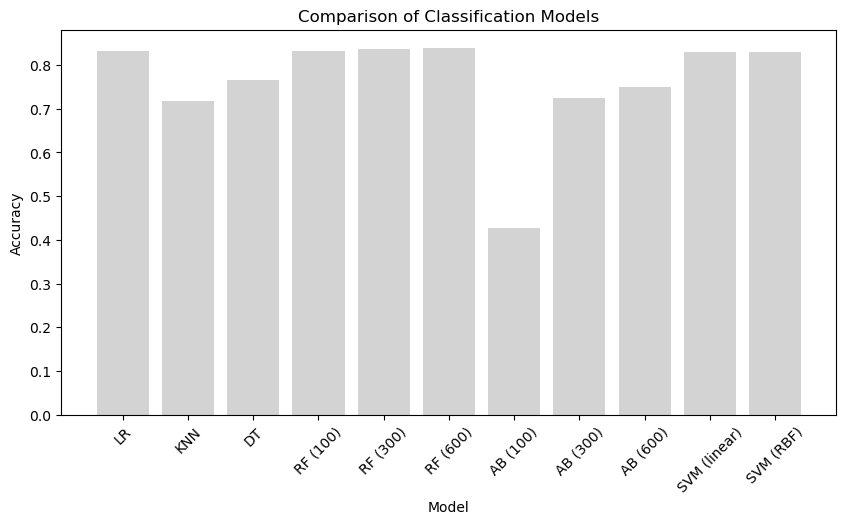

In [35]:
model_scores = {
    "LR": accuracy_score(y_test, y_pred_log_reg),
    "KNN": accuracy_score(y_test, y_pred_knn),
    "DT": accuracy_score(y_test, y_pred_dt),
    "RF (100)": accuracy_score(y_test, y_pred_rf1),
    "RF (300)": accuracy_score(y_test, y_pred_rf2),
    "RF (600)": accuracy_score(y_test, y_pred_rf3),
    "AB (100)": accuracy_score(y_test, y_pred_ab1),
    "AB (300)": accuracy_score(y_test, y_pred_ab2),
    "AB (600)": accuracy_score(y_test, y_pred_ab3),
    "SVM (linear)": accuracy_score(y_test, y_pred_svm_linear),
    "SVM (RBF)": accuracy_score(y_test, y_pred_svm_rbf)
}

plt.figure(figsize=(10, 5))
plt.bar(model_scores.keys(), model_scores.values(), color="lightgrey")
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.title("Comparison of Classification Models")
plt.xticks(rotation=45)
plt.show()

### Model Training Time (mac M1 processor - single core utilization)

| Model | Training Time |
|-------|---------------|
|Logistic Regression| 1 minute 37 seconds|
|KNN |1 minute 4 seconds|
|Decision Tree |23 seconds|
|Random Forest (100 estimators) |1 minute 23 seconds|
|Random Forest (300 estimators) |3 minutes 59 seconds|
|Random Forest (600 estimators) |7 minutes 55 seconds|
|Support Vector Machine (linear) |28 minutes 46 seconds|
|Support Vector Machine (RBF kernel) |49 minutes 52 seconds|
|AdaBoost (100 estimators) |3 minutes 17 seconds|
|AdaBoost (300 estimators) |16 minutes 4 seconds|
|AdaBoost (600 estimators) |39 minutes 31 seconds|

### Reflections on Model Performance

Logistic Regression performed surprisingly well, achieving 83.3% accuracy, which was nearly on par with the best-performing Random Forest model. Given its simplicity, this suggests that a linear decision boundary captures much of the signal in this dataset. Another advantage of Logistic Regression was its relatively fast training time (~1.5 minutes) compared to other models.

One major challenge in this dataset is high dimensionality, with nearly 10,000 bag-of-words features. This likely contributed to SVM’s struggles, as both the linear and RBF-kernel versions took exceptionally long to train (~28 and 50 minutes, respectively).

AdaBoost’s performance was unexpectedly low—its best accuracy was only ~75%. Since AdaBoost is based on decision trees, I initially expected it to perform on par with Random Forest. One possible reason for the underperformance of AdaBoost is that it relies on boosting weak learners, which might not be effective in a high-dimensional space where simple decision stumps struggle to capture complex patterns. I increased the number of AdaBoost learners in addition to the max depth, but beyond 300 learners, this seemed to have little effect. Perhaps more depth would yield better results, but this becomes computationally expensive (AdaBoost rivaled SVM for being the most compute hungry).  

In contrast, Random Forest did the best of all the models. Given these results, I decided to focus on Random Forest for further hyperparameter tuning.

### Hyperparameter Tuning for Random Forest

With the results above showing that random forest had the best accuracy, I decided to experiment with random forest hyperparameter tuning to see if I could optimize performance further. I wanted to see if limiting the maximum depth of trees in the model could improve the accuracy.

The `rf3` model above was set with the default max_depth=None setting, which allows trees to grow until each node is pure (i.e., every leaf node contains only one class). I hypothesized that this untamed growth may have caused overfitting and that further improvement could be gained by limiting the tree depth.

To test if there were any improvements to be found in limiting the max depth, I conducted a grid search across three levels of tree depth - 10, 20, and 30. I also modulated several other parameters in the grid search:

* n_estimators: Number of trees in the forest.
* max_depth: Maximum depth of trees (to test if limiting depth improves generalization).
* min_samples_split: Minimum number of samples required to split an internal node.
* min_samples_leaf: Minimum number of samples required to be at a leaf node.

I then evaluated different combinations of these parameters using 3-fold cross validation on the training set to test my hypothesis that max depth trees were overfitting.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rf_param_grid = {
    'n_estimators': [600, 800, 1000],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestClassifier(random_state=42, n_jobs=-1)
rf_grid_search = GridSearchCV(estimator=rf, param_grid=rf_param_grid,
                              cv=3, verbose=2, n_jobs=-1)
rf_grid_search.fit(X_train, y_train)

print("Best Parameters:", rf_grid_search.best_params_)
print("Best Accuracy:", rf_grid_search.best_score_)


Fitting 3 folds for each of 81 candidates, totalling 243 fits
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=600; total time= 1.3min
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=600; total time= 1.3min
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=600; total time= 1.3min
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=600; total time= 1.4min
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=800; total time= 1.5min
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=800; total time= 1.5min
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=800; total time= 1.5min
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time= 1.6min
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time= 1.6min
[CV] END max_depth=10, min_

These results suggest that limiting max_depth to 30 **does not significantly improve accuracy** over the default setting (comparing with the the `rf3` model) and that my hypothesis was likely incorrect. Reducing min_samples_leaf and min_samples_split to their lowest values (1 and 2) indicates that deep trees still perform best on this dataset.

### Hyperparameter Tuning Heatmap Visualization

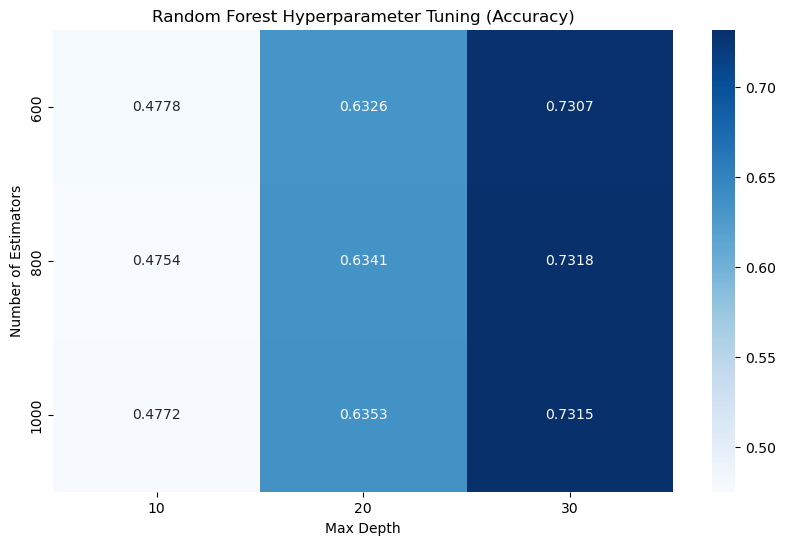

In [41]:
import seaborn as sns

results = rf_grid_search.cv_results_
df_results = pd.DataFrame(results)

df_results = df_results[['param_n_estimators', 'param_max_depth', 'mean_test_score']]
df_results['param_n_estimators'] = df_results['param_n_estimators'].astype(int)
df_results['param_max_depth'] = df_results['param_max_depth'].astype(int)

df_results = df_results.groupby(['param_n_estimators', 'param_max_depth'])['mean_test_score'].mean().reset_index()
df_pivot = df_results.pivot(index='param_n_estimators', columns='param_max_depth', values='mean_test_score')

plt.figure(figsize=(10, 6))
sns.heatmap(df_pivot, annot=True, fmt=".4f", cmap="Blues")
plt.xlabel("Max Depth")
plt.ylabel("Number of Estimators")
plt.title("Random Forest Hyperparameter Tuning (Accuracy)")
plt.show()


Here we see that increasing the max depth from 10 to 30 boosted accuracy. Adding more trees (n_estimators) beyond 800 doesn’t seem to yield much improvement.

## Conclusion

In this project, I set out to build a classifier that could automate the categorization of IT support tickets. Through a series of experiments with different models, Random Forest consistently delivered the best performance, achieving an accuracy of ~83-84% on the test set.

In an attempt to refine the model further, I performed hyperparameter tuning to explore whether limiting tree depth could improve generalization. The results showed that increasing max depth did improve accuracy, while adding more trees (beyond 800 estimators) had diminishing returns. The slight dip in accuracy with 1000 trees suggests that adding complexity doesn’t always translate to better performance.

These results are just the beginning of what would be needed to build a real-world model for the purpose of classifying and routing IT support tickets. 

Future work could include:

Exploring TF-IDF or word embeddings instead of a simple Bag-of-Words model.  
Trying more advanced models like Gradient Boosting or Neural Networks.  
Fine-tuning hyperparameters further.